<div style="
    border:1px solid #ffffffff;
    padding:15px;
    border-radius:8px;
    background:#000;
">
<h3 style="margin-top:0;">Indices Project</h3>
</div>

<div style="
    border:1px solid #ffffffff;
    padding:15px;
    border-radius:8px;
    background:#000;
">
<h3 style="margin-top:0;">Part 1: Import of necessary libraries & data </h3>
</div>


In [1]:
import numpy as np
import pandas as pd 
import sklearn as sl
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import yfinance as yf

In [2]:
numpy_version = np.__version__
pandas_version = pd.__version__
sklearn_version = sl.__version__
matplotlib_version = matplotlib.__version__
seaborn_version = sns.__version__
yahoo_version = yf.__version__
print(f"Numpy version: {numpy_version}")
print(f"Pandas version: {pandas_version}")
print(f"Sklearn version: {sklearn_version}")
print(f"Matplotlib version: {matplotlib_version}")
print(f"Seaborn version: {seaborn_version}")
print(f"yFinance version: {yahoo_version}")

Numpy version: 2.3.5
Pandas version: 2.3.3
Sklearn version: 1.7.1
Matplotlib version: 3.10.6
Seaborn version: 0.13.2
yFinance version: 0.2.66


In [3]:
df = pd.read_excel(r"Top5_Indices.xlsx", sheet_name = "Trading Days")
df['Date'] = pd.to_datetime(df['Date'])
print(df.head())

        Date  Numeric Date      S&P 500  S&P 500 % Return     Dow Jones  \
0 2000-01-03             1  1455.219971          0.000000  11357.509766   
1 2000-01-04             2  1399.420044         -0.038345  10997.929688   
2 2000-01-05             3  1402.109985          0.001922  11122.650391   
3 2000-01-06             4  1403.449951          0.000956  11253.259766   
4 2000-01-07             5  1441.469971          0.027090  11522.559570   

   Dow Jones % Return  Nasdaq Composite  Nasdaq Composite % Return  \
0            0.000000       4131.149902                   0.000000   
1           -0.031660       3901.689941                  -0.055544   
2            0.011340       3877.540039                  -0.006190   
3            0.011743       3727.129883                  -0.038790   
4            0.023931       3882.620117                   0.041718   

   Russell 2000  Russell 2000 % Return   Nasdaq 100  Nasdaq 100 % Return  
0    496.420013               0.000000  3790.550049  

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6522 entries, 0 to 6521
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       6522 non-null   datetime64[ns]
 1   Numeric Date               6522 non-null   int64         
 2   S&P 500                    6522 non-null   float64       
 3   S&P 500 % Return           6522 non-null   float64       
 4   Dow Jones                  6522 non-null   float64       
 5   Dow Jones % Return         6522 non-null   float64       
 6   Nasdaq Composite           6522 non-null   float64       
 7   Nasdaq Composite % Return  6522 non-null   float64       
 8   Russell 2000               6522 non-null   float64       
 9   Russell 2000 % Return      6522 non-null   float64       
 10  Nasdaq 100                 6522 non-null   float64       
 11  Nasdaq 100 % Return        6522 non-null   float64       
dtypes: dat

In [5]:
print(df.shape)

(6522, 12)


<div style="
    border:1px solid #ffffffff;
    padding:15px;
    border-radius:8px;
    background:#000;
">
<h3 style="margin-top:0;">Part 2: Testing Different Regressions </h3>
</div>

In [7]:
from sklearn.model_selection import train_test_split

X = df["Numeric Date"].values.reshape(-1, 1)

y = df[["S&P 500", "Dow Jones", "Nasdaq Composite", 
        "Russell 2000", "Nasdaq 100"]].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [8]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error

models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Polynomial (3)": make_pipeline(PolynomialFeatures(3), LinearRegression()),
    "Polynomial (5)": make_pipeline(PolynomialFeatures(5), LinearRegression())
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    r2 = r2_score(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    
    results[name] = {"R2": r2, "MSE": mse}

results


{'Linear': {'R2': -4.851779985997342, 'MSE': 63537140.42632431},
 'Ridge': {'R2': -4.8517799863174815, 'MSE': 63537140.42945471},
 'Lasso': {'R2': -4.8517851331224, 'MSE': 63537153.01423838},
 'Polynomial (3)': {'R2': 0.19077576936676358, 'MSE': 6816733.352639936},
 'Polynomial (5)': {'R2': -6.768084490054308, 'MSE': 23338011.879121356}}

> **Degree 3 Polynomial Regression Shows Best Fit**

> > Linear, Ridge, and Lasso regression models assume a straight-line relationship between time and index values, which makes them too simple for financial market data that naturally curves and fluctuates over long periods. Even with regularization, Ridge and Lasso remain fundamentally linear models, so they cannot capture the nonlinear growth patterns present in the indexes, resulting in strongly negative R² scores.

> > Polynomial regression adds flexibility by allowing the model to follow curved trends, and the degree-3 polynomial performs significantly better because it captures the overall upward movement without becoming overly complex. Among the tested models, the degree-3 polynomial provides the best balance between fit and generalization, avoiding the overfitting seen in the degree-5 polynomial.

<div style="
    border:1px solid #ffffffff;
    padding:15px;
    border-radius:8px;
    background:#000;
">
<h3 style="margin-top:0;">Part 3: Polynomial Regression </h3>
</div>

In [9]:
degrees = [1, 2, 3, 4, 5]

targets = {
    "S&P 500": df['S&P 500'].values,
    "Dow Jones": df['Dow Jones'].values,
    "Nasdaq Composite": df['Nasdaq Composite'].values,
    "Russell 2000": df['Russell 2000'].values,
    "Nasdaq 100": df['Nasdaq 100'].values
}

X = df["Numeric Date"].values.reshape(-1,1)

results = {name: {} for name in targets.keys()}

for name, y in targets.items():
    for d in degrees:
        poly = PolynomialFeatures(degree=d)
        X_poly = poly.fit_transform(X)
        model = LinearRegression().fit(X_poly, y)
        y_pred = model.predict(X_poly)

        mse = mean_squared_error(y, y_pred)
        rmse = np.sqrt(mse)

        results[name][d] = {"MSE": mse, "RMSE": rmse}

for name, metrics in results.items():
    print(f"--- {name} ---")
    for degree, vals in metrics.items():
        print(f"Degree {degree}: MSE = {vals['MSE']:.2f}, RMSE = {vals['RMSE']:.2f}")
    print()


--- S&P 500 ---
Degree 1: MSE = 520039.08, RMSE = 721.14
Degree 2: MSE = 77892.44, RMSE = 279.09
Degree 3: MSE = 60561.40, RMSE = 246.09
Degree 4: MSE = 60610.91, RMSE = 246.19
Degree 5: MSE = 61230.78, RMSE = 247.45

--- Dow Jones ---
Degree 1: MSE = 19877509.95, RMSE = 4458.42
Degree 2: MSE = 2975491.84, RMSE = 1724.96
Degree 3: MSE = 2843031.89, RMSE = 1686.13
Degree 4: MSE = 2780403.68, RMSE = 1667.45
Degree 5: MSE = 2803100.55, RMSE = 1674.25

--- Nasdaq Composite ---
Degree 1: MSE = 7553570.06, RMSE = 2748.38
Degree 2: MSE = 1267976.59, RMSE = 1126.04
Degree 3: MSE = 1071664.66, RMSE = 1035.21
Degree 4: MSE = 1086717.18, RMSE = 1042.46
Degree 5: MSE = 1105355.70, RMSE = 1051.36

--- Russell 2000 ---
Degree 1: MSE = 43315.32, RMSE = 208.12
Degree 2: MSE = 24782.15, RMSE = 157.42
Degree 3: MSE = 24169.11, RMSE = 155.46
Degree 4: MSE = 23334.30, RMSE = 152.76
Degree 5: MSE = 23286.51, RMSE = 152.60

--- Nasdaq 100 ---
Degree 1: MSE = 10290526.46, RMSE = 3207.89
Degree 2: MSE = 15231

> **Degree 3 Polynomial Regression Remains Best Fit**

>> Given the negligible difference in MSE/RMSE between 3rd and 4th degree polynomials for all indices, a 3rd-degree polynomial regression was selected for simplicity and to avoid overfitting.

In [10]:
X = df['Numeric Date'].values.reshape(-1, 1)

targets = {
    "S&P 500": df['S&P 500'].values,
    "Dow Jones": df['Dow Jones'].values,
    "Nasdaq Composite": df['Nasdaq Composite'].values,
    "Russell 2000": df['Russell 2000'].values,
    "Nasdaq 100": df['Nasdaq 100'].values,
}

degree = 3

poly = PolynomialFeatures(degree=degree)
X_poly = poly.fit_transform(X)

models = {}
predictions = {}
errors = {}

for name, y in targets.items():
    model = LinearRegression()
    model.fit(X_poly, y)

    y_pred = model.predict(X_poly)

    models[name] = model
    predictions[name] = y_pred
    errors[name] = mean_squared_error(y, y_pred)

    print(f"--- {name} ---")
    print("Coefficients:", model.coef_)
    print("Intercept:", model.intercept_)
    print("MSE:", errors[name])
    print()

N = 365  # <--- future days to predict

last_numeric_date = df['Numeric Date'].max()

future_numeric = np.arange(
    last_numeric_date + 1,
    last_numeric_date + N + 1
).reshape(-1, 1)

future_poly = poly.transform(future_numeric)

future_predictions = {
    "Numeric Date": future_numeric.flatten()
}

print("\nFuture Predictions:")
for name, model in models.items():
    pred = model.predict(future_poly)
    future_predictions[name] = pred
    print(f"{name}: First future value = {pred[0]:.2f}")

future_df = pd.DataFrame(future_predictions)


--- S&P 500 ---
Coefficients: [ 0.00000000e+00 -4.63352637e-02 -1.69455125e-05  8.19719019e-09]
Intercept: 1243.0154659072582
MSE: 60561.39976709827

--- Dow Jones ---
Coefficients: [ 0.00000000e+00 -1.17194460e+00  2.93237705e-04  2.26618322e-08]
Intercept: 10868.782002115586
MSE: 2843031.8941175113

--- Nasdaq Composite ---
Coefficients: [ 0.00000000e+00 -4.49615816e-01 -1.67541087e-05  2.75883721e-08]
Intercept: 2760.6466377176957
MSE: 1071664.6640701261

--- Russell 2000 ---
Coefficients: [ 0.00000000e+00 -7.57890681e-02  4.22683130e-05 -1.54168629e-09]
Intercept: 535.0961796196366
MSE: 24169.110953803684

--- Nasdaq 100 ---
Coefficients: [ 0.00000000e+00 -1.80967631e-01 -1.45361419e-04  4.14232206e-08]
Intercept: 2281.424294842199
MSE: 1080566.9921973636


Future Predictions:
S&P 500: First future value = 6246.23
Dow Jones: First future value = 45314.49
Nasdaq Composite: First future value = 20430.46
Russell 2000: First future value = 2298.71
Nasdaq 100: First future value = 22711

In [11]:
print("\nFuture prediction table (head):")
print(future_df.head(15))


Future prediction table (head):
    Numeric Date      S&P 500     Dow Jones  Nasdaq Composite  Russell 2000  \
0           9470  6246.226006  45314.486279      20430.462172   2298.713612   
1           9471  6248.064333  45324.966195      20437.118450   2299.023604   
2           9472  6249.903092  45335.447984      20443.776263   2299.333592   
3           9473  6251.742282  45345.931648      20450.435610   2299.643578   
4           9474  6253.581905  45356.417186      20457.096492   2299.953561   
5           9475  6255.421960  45366.904599      20463.758908   2300.263540   
6           9476  6257.262447  45377.393887      20470.422860   2300.573516   
7           9477  6259.103366  45387.885050      20477.088346   2300.883490   
8           9478  6260.944717  45398.378087      20483.755368   2301.193460   
9           9479  6262.786501  45408.873000      20490.423925   2301.503427   
10          9480  6264.628717  45419.369789      20497.094017   2301.813390   
11          9481  6

<div style="
    border:1px solid #ffffffff;
    padding:15px;
    border-radius:8px;
    background:#000;
">
<h3 style="margin-top:0;">Part 4: Plotting Graph of Real vs Predicted Data </h3>
</div>

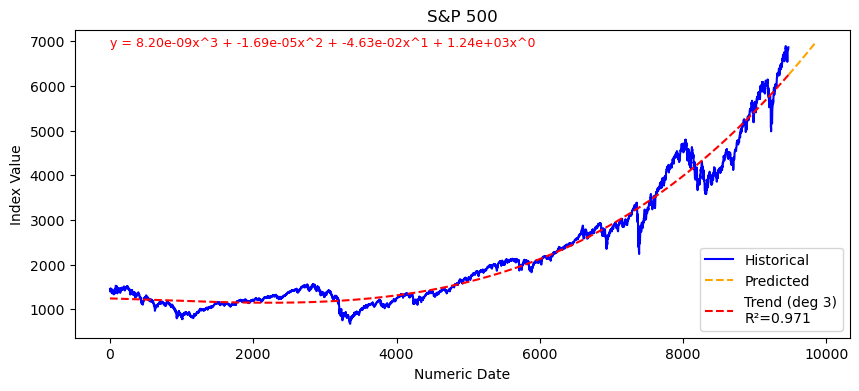

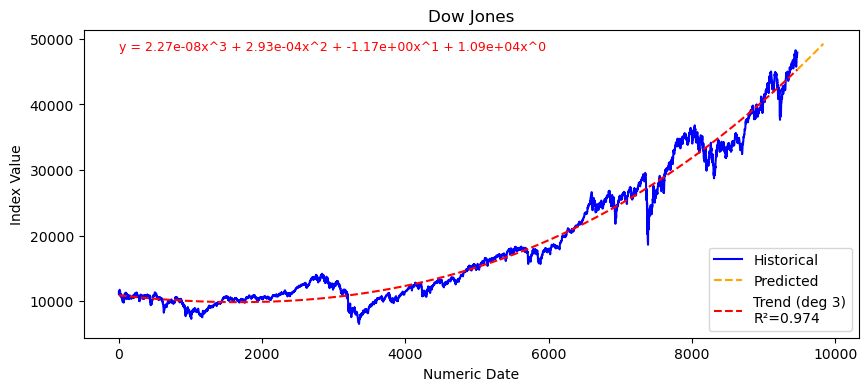

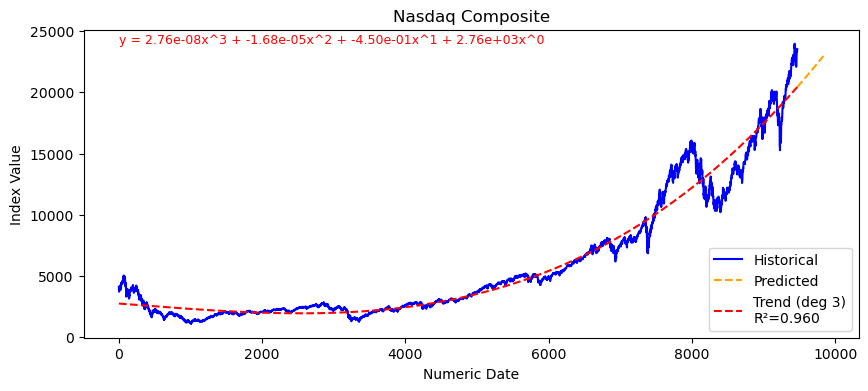

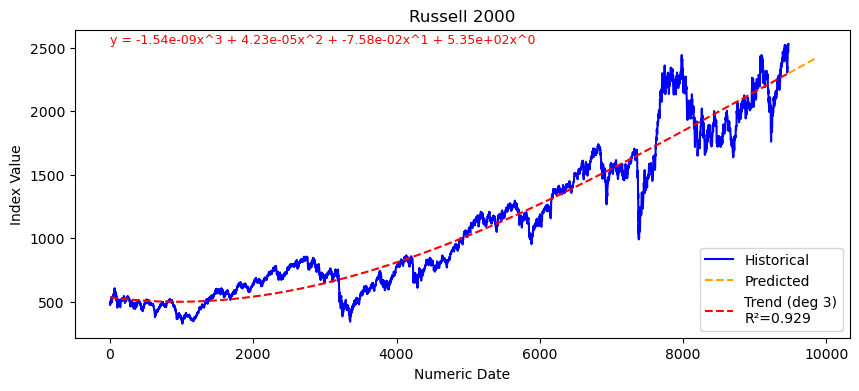

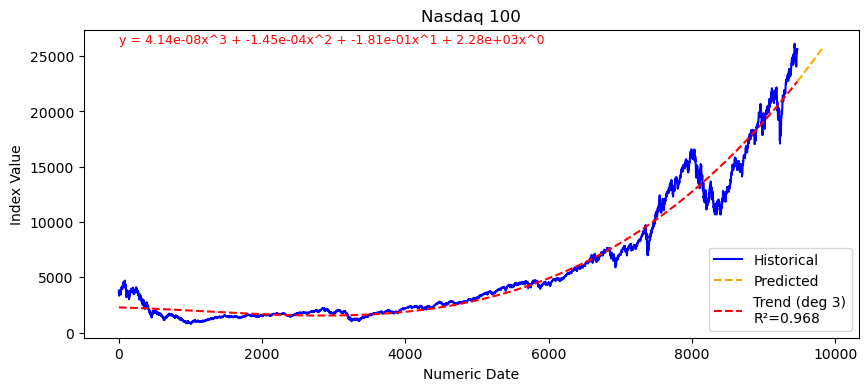

In [12]:
degree = 3

columns = ["S&P 500", "Dow Jones", "Nasdaq Composite", "Russell 2000", "Nasdaq 100"]

for col in columns:
    plt.figure(figsize=(10,4))
    
    x_hist = df["Numeric Date"]
    y_hist = df[col]
    plt.plot(x_hist, y_hist, label="Historical", color="blue")
    
    x_pred = future_df["Numeric Date"]
    y_pred = future_df[col]
    plt.plot(x_pred, y_pred, label="Predicted", color="orange", linestyle='--')
    
    coeffs = np.polyfit(x_hist, y_hist, degree)
    p = np.poly1d(coeffs)
    y_trend = p(x_hist)
    
    residuals = y_hist - y_trend
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_hist - np.mean(y_hist))**2)
    r_squared = 1 - (ss_res / ss_tot)
    
    plt.plot(x_hist, y_trend, "r--", label=f"Trend (deg {degree})\nR²={r_squared:.3f}")
    
    eq_text = "y = " + " + ".join([f"{coeff:.2e}x^{degree-i}" for i, coeff in enumerate(coeffs)])
    plt.text(x_hist.min(), y_hist.max(), eq_text, fontsize=9, color='red')
    
    plt.title(col)
    plt.xlabel("Numeric Date")
    plt.ylabel("Index Value")
    plt.legend()
    plt.show()


> **2000 to 2026**
> > The predictions depict a fall of all stocks before a steady increase back up to peak values shown in 2025 for 2026

<div style="
    border:1px solid #ffffffff;
    padding:15px;
    border-radius:8px;
    background:#000;
">
<h3 style="margin-top:0;">Part 5: Charting % Return </h3>
</div>

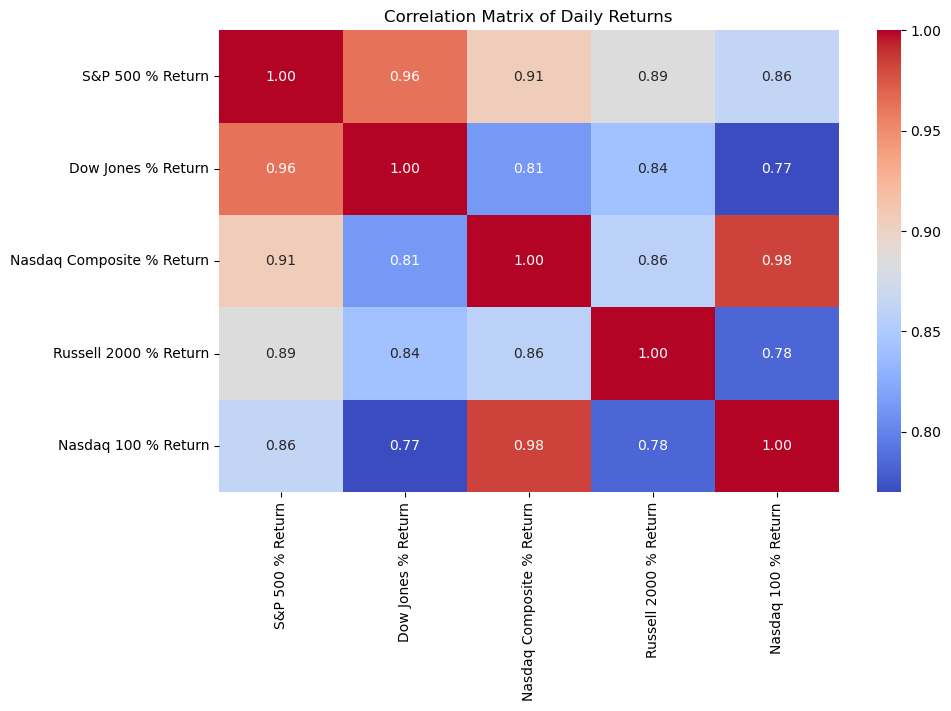

,S&P 500 % Return,Dow Jones % Return,Nasdaq Composite % Return,Russell 2000 % Return,Nasdaq 100 % Return
S&P 500 % Return,1.000000,0.962288,0.905340,0.885591,0.863875
Dow Jones % Return,0.962288,1.000000,0.812273,0.840938,0.769850
Nasdaq Composite % Return,0.905340,0.812273,1.000000,0.858382,0.983686
Russell 2000 % Return,0.885591,0.840938,0.858382,1.000000,0.784023
Nasdaq 100 % Return,0.863875,0.769850,0.983686,0.784023,1.000000


In [13]:
return_cols = [
    'S&P 500 % Return',
    'Dow Jones % Return',
    'Nasdaq Composite % Return',
    'Russell 2000 % Return',
    'Nasdaq 100 % Return'
]

returns = df[return_cols]

corr_return = returns.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr_return, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Daily Returns")
plt.show()

corr_return

> **This heatmap shows the correlation coefficients between five major U.S. stock indices: S&P 500, Dow Jones, Nasdaq Composite, Russell 2000, and Nasdaq 100:**

>> S&P 500 has a correlations above 0.85 for all other markets including a strong 0.96 with Dow Jones. Both represent large-cap U.S. companies/the same segment of the market.

>> Nasdaq Composite and Nasdaq 100 has the highest correlation with 0.98. Nasdaq 100 is a subset of the Nasdaq Composite so this pattern fits.

>> S&P 500 and Nasdaq Composite has a correlation of 0.90. Tech significantly influences the S&P, however, the S&P is more diversified (healthcare, financials, energy, etc.), so correlation isn’t perfect.

>> Russell 2000 tracks smaller-cap companies, which explains the slightly weaker correlation compared to large-cap indices (0.78 to 0.88). Small-cap stocks behave differently making it the odd man out compared to the others.

>> The markets are strongly interconnected.

>> Diversifying only among these indices offers limited risk reduction, since most move together.

>> Small-cap stocks (Russell 2000) provide slightly different behavior, which could offer a small diversification benefit.

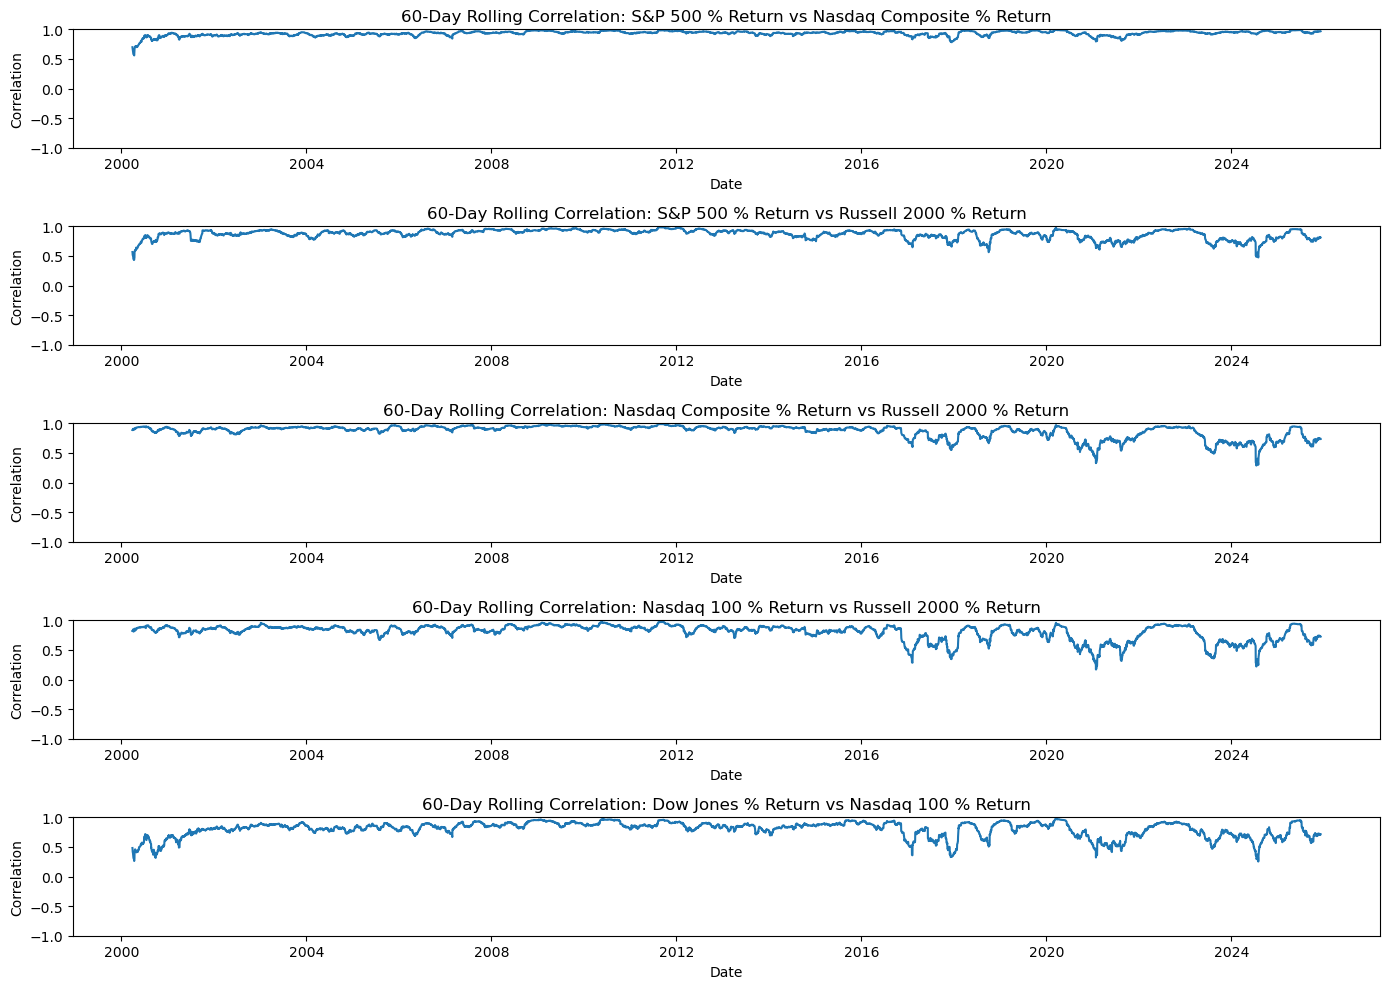

In [16]:
window = 60

pairs = [
    ('S&P 500 % Return', 'Nasdaq Composite % Return'),
    ('S&P 500 % Return', 'Russell 2000 % Return'),
    ('Nasdaq Composite % Return', 'Russell 2000 % Return'),
    ('Nasdaq 100 % Return', 'Russell 2000 % Return'),
    ('Dow Jones % Return', 'Nasdaq 100 % Return')
]

plt.figure(figsize=(14,10))

for i, (col1, col2) in enumerate(pairs, 1):
    rolling_corr = df[col1].rolling(window).corr(df[col2])
    
    plt.subplot(len(pairs), 1, i)
    plt.plot(df['Date'], rolling_corr)
    plt.title(f'{window}-Day Rolling Correlation: {col1} vs {col2}')
    plt.ylabel("Correlation")
    plt.xlabel("Date")
    plt.ylim(-1,1)

plt.tight_layout()
plt.show()


> **The 60-day rolling correlation between certain paired indexes are showed above. These pairs are:**

>> S&P 500 ↔ Nasdaq Composite → tech vs broad market

>> S&P 500 ↔ Russell 2000 → large vs small cap behavior

>> Nasdaq Composite ↔ Russell 2000 → tech vs small cap

>> Nasdaq 100 ↔ Russell 2000 → tech-heavy vs small cap

>> Dow ↔ Nasdaq 100 → old economy vs tech

>>> While the majority of the graph shows a high rolling correlation, it is not constant with noticeable peaks and valleys. Peaks in the rolling correlations indicate periods where the indexes move closely together, often reflecting strong macroeconomic drivers, broad market rallies, or systemic shocks when all sectors react in unison. Valleys, on the other hand, highlight periods of divergence, where certain indexes behave differently from the broader market, often due to sector rotations, earnings-specific events, or changes in investor sentiment.

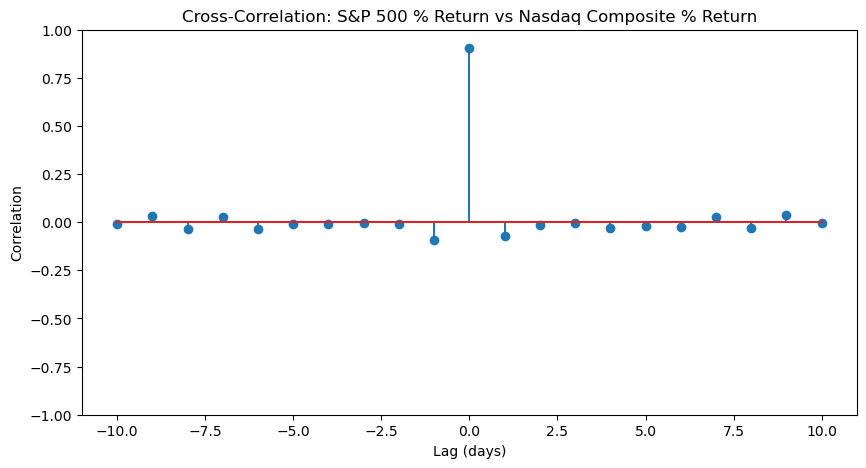

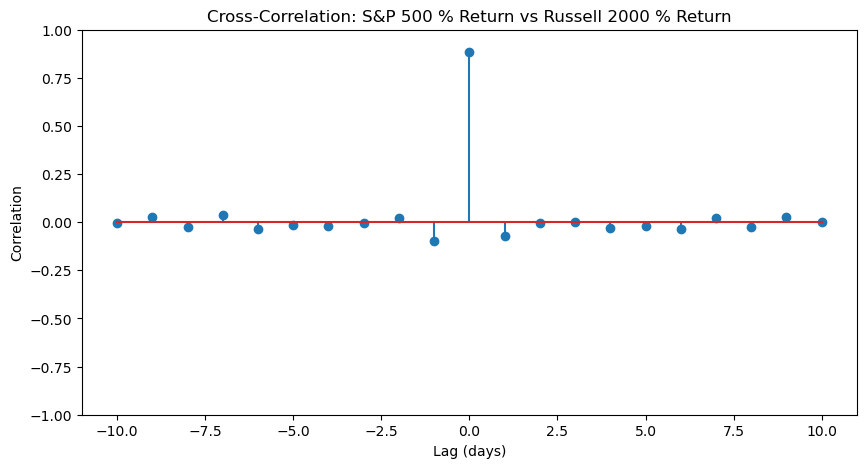

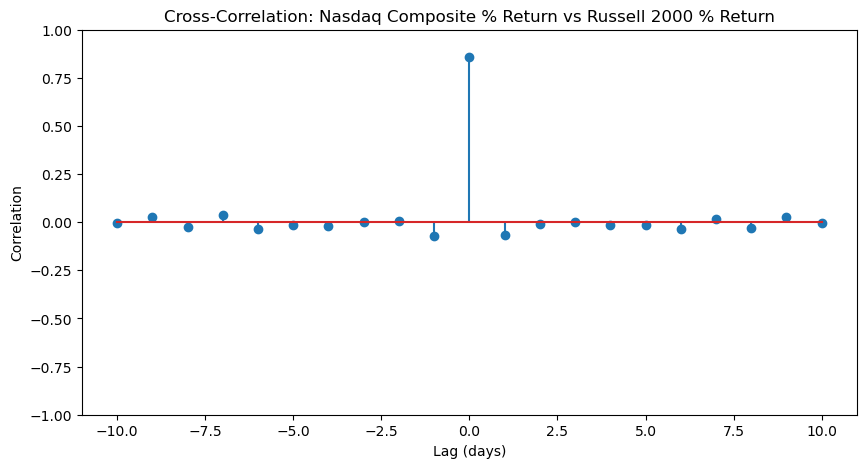

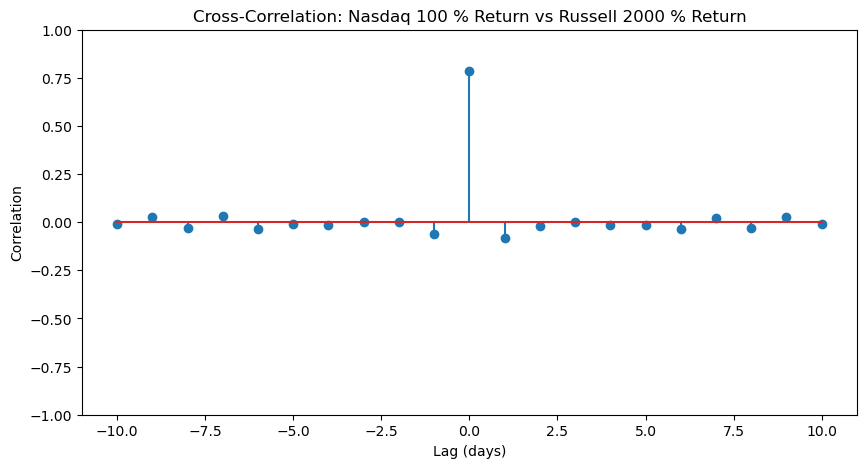

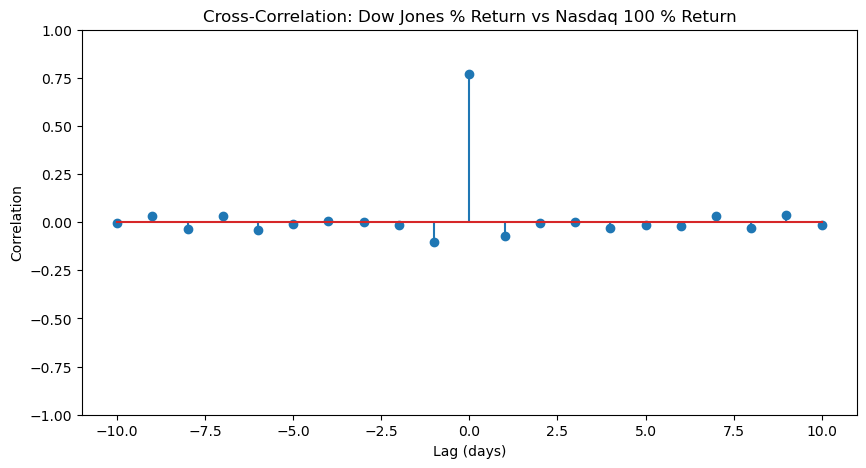

In [17]:
pairs = [
    ('S&P 500 % Return', 'Nasdaq Composite % Return'),
    ('S&P 500 % Return', 'Russell 2000 % Return'),
    ('Nasdaq Composite % Return', 'Russell 2000 % Return'),
    ('Nasdaq 100 % Return', 'Russell 2000 % Return'),
    ('Dow Jones % Return', 'Nasdaq 100 % Return')
]

lags = range(-10, 11)

for col1, col2 in pairs:
    series1 = df[col1].dropna()
    series2 = df[col2].dropna()
    
    cross_corr = [series1.corr(series2.shift(lag)) for lag in lags]
    
    plt.figure(figsize=(10,5))
    plt.stem(lags, cross_corr)
    plt.title(f"Cross-Correlation: {col1} vs {col2}")
    plt.xlabel("Lag (days)")
    plt.ylabel("Correlation")
    plt.ylim(-1,1)
    plt.show()


> **Strongest Correlation at Lag of 0**

>> The cross-correlation analysis shows that nearly all index pairs have the strongest correlation at lag 0, indicating that the indexes move together on the same day. Smaller differences at positive or negative lags suggest only minor lead-lag behavior, meaning that none of these indexes consistently leads the others by multiple days.

<div style="
    border:1px solid #ffffffff;
    padding:15px;
    border-radius:8px;
    background:#000;
">
<h3 style="margin-top:0;">Part 6: Calculating Risk </h3>
</div>

In [19]:
returns_cols = [
    'S&P 500 % Return',
    'Dow Jones % Return',
    'Nasdaq Composite % Return',
    'Russell 2000 % Return',
    'Nasdaq 100 % Return'
]

returns = df[returns_cols]

volatility = returns.std() * np.sqrt(252)
print("Annualized Volatility:")
print(volatility)


Annualized Volatility:
S&P 500 % Return             0.193828
Dow Jones % Return           0.183947
Nasdaq Composite % Return    0.249318
Russell 2000 % Return        0.244109
Nasdaq 100 % Return          0.273723
dtype: float64


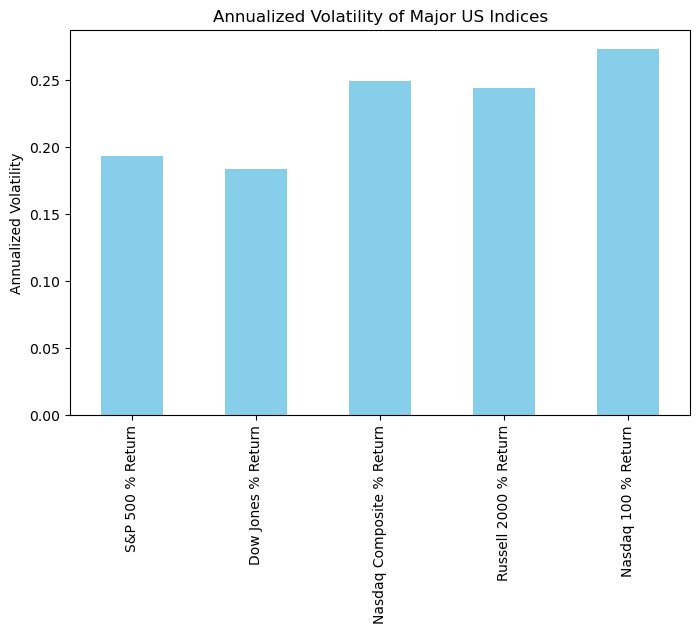

In [20]:
volatility.plot(kind='bar', figsize=(8,5), color='skyblue')
plt.ylabel("Annualized Volatility")
plt.title("Annualized Volatility of Major US Indices")
plt.show()


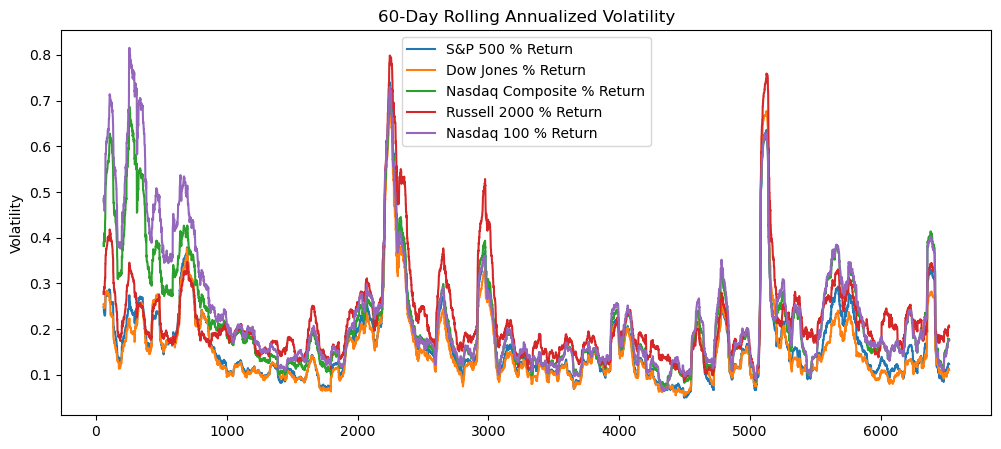

In [21]:
rolling_vol = returns.rolling(window=60).std() * np.sqrt(252)
rolling_vol.plot(figsize=(12,5))
plt.title("60-Day Rolling Annualized Volatility")
plt.ylabel("Volatility")
plt.show()


> **Measured Volatility**

>> With 252 trading days in the year, the annualized volatility provides a measure of perceived risk. Among the major indexes, the Nasdaq 100 has the highest volatility at 0.27, indicating larger daily fluctuations and higher risk, while the Dow Jones has the lowest at 0.18, reflecting comparatively more stable movements.

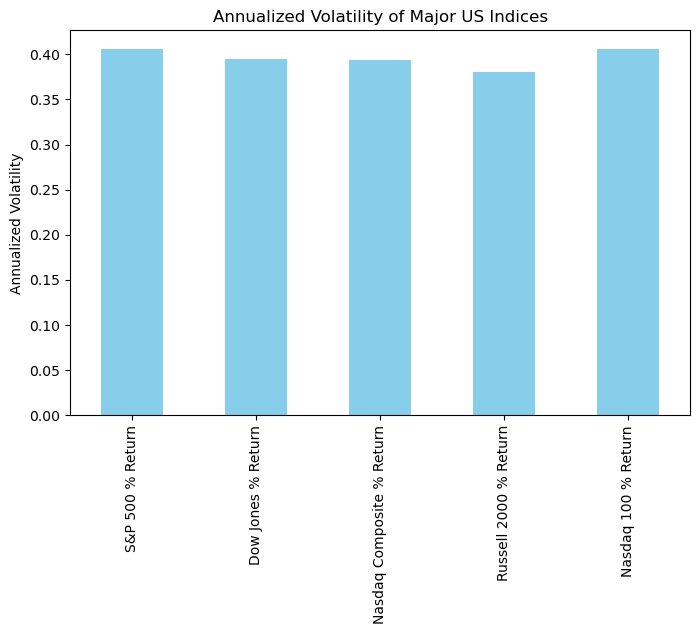

In [22]:
sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252)
sharpe_ratio

sharpe_ratio.plot(kind='bar', figsize=(8,5), color='skyblue')
plt.ylabel("Annualized Volatility")
plt.title("Annualized Volatility of Major US Indices")
plt.show()

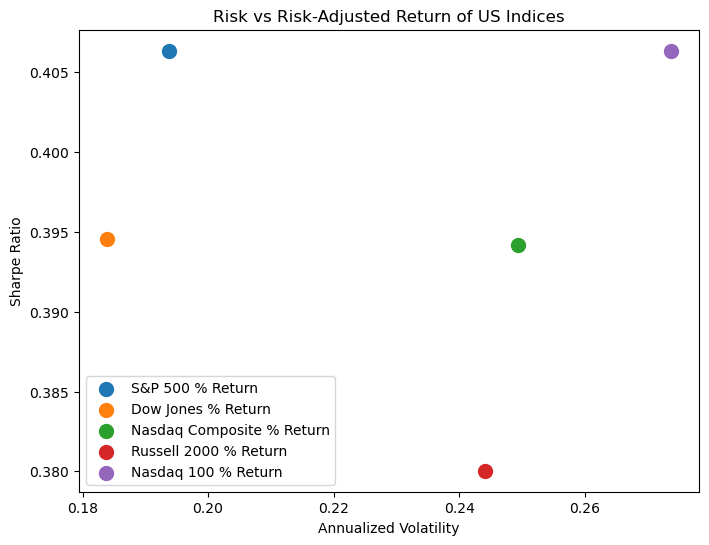

In [23]:
plt.figure(figsize=(8,6))
for idx in volatility.index:
    plt.scatter(volatility[idx], sharpe_ratio[idx], label=idx, s=100)

plt.xlabel("Annualized Volatility")
plt.ylabel("Sharpe Ratio")
plt.title("Risk vs Risk-Adjusted Return of US Indices")
plt.legend()
plt.show()

> **All Five Major U.S. Indexes Exhibit Moderate Positive Risk-Adjusted Returns**

>> With Sharpe ratios ranging from 0.38 for the Russell 2000 to 0.41 for the S&P 500 and Nasdaq 100, indicating that, relative to their volatility, the S&P 500 and Nasdaq 100 have delivered slightly more efficient performance, while the Russell 2000 has been slightly less efficient.

>> Higher Sharpe at lower volatility → efficient and stable index

>> Higher volatility with similar Sharpe → more fluctuations for similar returns

<div style="
    border:1px solid #ffffffff;
    padding:15px;
    border-radius:8px;
    background:#000;
">
<h3 style="margin-top:0;">Part 7: Major Events </h3>
</div>

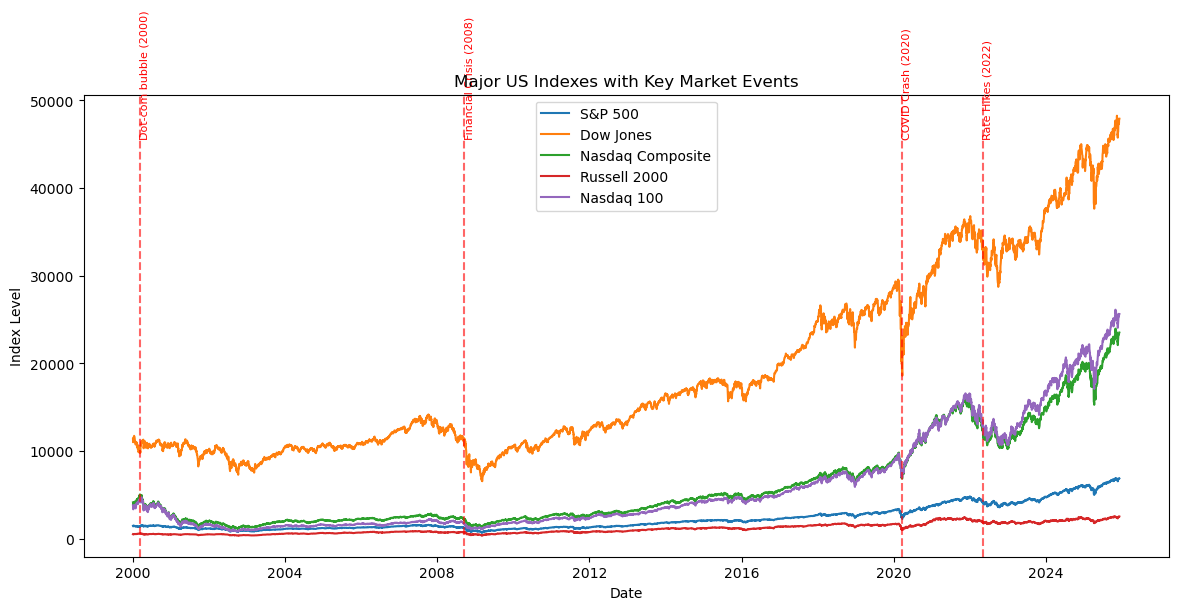

In [24]:
events = {
    'Dot-com bubble (2000)': '2000-03-10',
    'Financial Crisis (2008)': '2008-09-15',
    'COVID Crash (2020)': '2020-03-16',
    'Rate Hikes (2022)': '2022-05-04'
}

index_cols = ["S&P 500", "Dow Jones", "Nasdaq Composite", "Russell 2000", "Nasdaq 100"]

plt.figure(figsize=(14,6))

for col in index_cols:
    plt.plot(df['Date'], df[col], label=col)

for event, date in events.items():
    plt.axvline(pd.to_datetime(date), color='red', linestyle='--', alpha=0.6)
    plt.text(pd.to_datetime(date), df[index_cols].max().max()*0.95, event,
             rotation=90, color='red', fontsize=8)

plt.title("Major US Indexes with Key Market Events")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.legend()
plt.show()



> **Major Events and Their Impact**

>> The four major events listed shows a steep valley in the key indexes followed by a market rebound.

In [25]:
window = 30
results = {}

for event, date in events.items():
    date = pd.to_datetime(date)
    results[event] = {}
    for col in returns_cols:
        vol_window = df[col].rolling(window=60).std() * np.sqrt(252)
        vol_event = vol_window.loc[(df['Date'] >= date - pd.Timedelta(days=window)) &
                                   (df['Date'] <= date + pd.Timedelta(days=window))]
        results[event][col] = vol_event.mean()

event_vol_df = pd.DataFrame(results).T
print(event_vol_df)


                         S&P 500 % Return  Dow Jones % Return  \
Dot-com bubble (2000)            0.237391            0.249522   
Financial Crisis (2008)          0.289623            0.279385   
COVID Crash (2020)               0.397202            0.422475   
Rate Hikes (2022)                0.239459            0.195061   

                         Nasdaq Composite % Return  Russell 2000 % Return  \
Dot-com bubble (2000)                     0.393017               0.285855   
Financial Crisis (2008)                   0.296849               0.330214   
COVID Crash (2020)                        0.400644               0.435875   
Rate Hikes (2022)                         0.336250               0.281245   

                         Nasdaq 100 % Return  
Dot-com bubble (2000)               0.476192  
Financial Crisis (2008)             0.312385  
COVID Crash (2020)                  0.408766  
Rate Hikes (2022)                   0.342650  


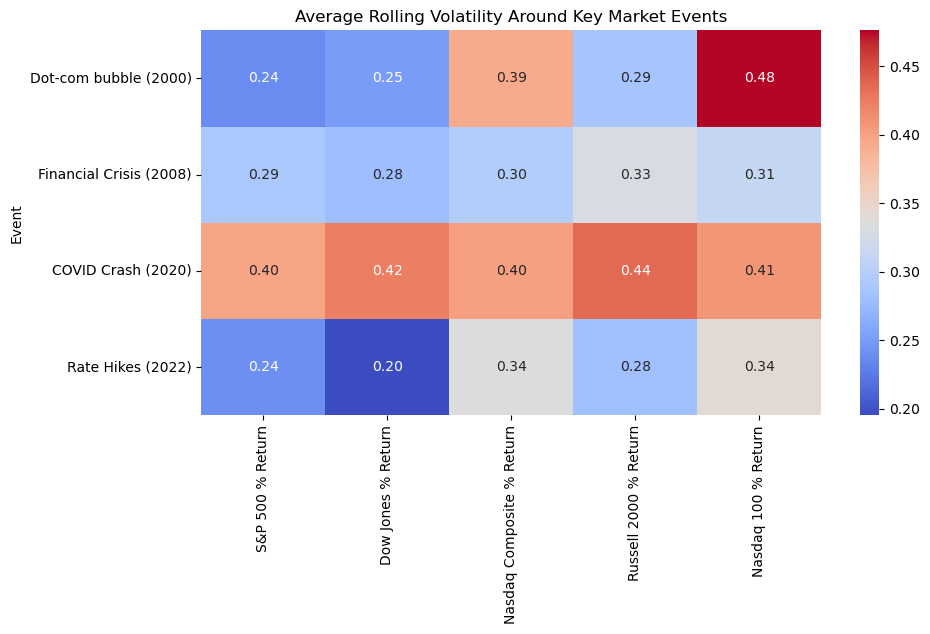

In [26]:

plt.figure(figsize=(10,5))
sns.heatmap(event_vol_df, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Average Rolling Volatility Around Key Market Events")
plt.ylabel("Event")
plt.show()

> **The Table Shows the Average Rolling Volatility of Each Major U.S. Index During Key Market Events.**
 
>> The Nasdaq 100 consistently exhibits the highest volatility, particularly during the Dot-com bubble (0.48) and the COVID crash (0.41), reflecting its sensitivity to tech-driven market movements. 

>> The Russell 2000 also shows elevated volatility during crises, highlighting the increased risk in small-cap stocks. 

>> Broad-market indexes like the S&P 500 and Dow Jones generally display lower volatility, indicating relative stability, though all indexes experience spikes during periods of systemic market stress.